In [59]:
import pandas as pd
import numpy as np
import pyodbc  
from datetime import datetime 
import matplotlib.pylab as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.stattools import adfuller # stationary or not 
from statsmodels.stats.diagnostic import acorr_ljungbox # white noice test
from statsmodels.tsa.stattools import arma_order_select_ic # AIC BIC
import statsmodels.api as sm # predict
from scipy import  stats
from statsmodels.graphics.api import qqplot
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools
import warnings
from sklearn.metrics import r2_score
from statsmodels.tsa.arima_model import ARIMA
warnings.filterwarnings('ignore')
from fbprophet import Prophet

In [60]:
conn = pyodbc.connect("Driver={ODBC Driver 13 for SQL Server};Server=yetidb01.database.windows.net;database=YETISQLDW01;uid=htian;PWD=HeLeNtIAn52!")
cursor = conn.cursor()

In [61]:
DF = pd.read_sql("SELECT S.CustomerID, C.Customer, S.OrderDate, S.Requested_Date, S.SalesOffice, S.OrderQty, P.ProductCategory, P.MasterSKU,S.sourcesystem FROM EDW_DS.ORDERFCT S  inner join [EDW].[PRODUCT_DIM] P ON P.ProductID = S.ProductID  left join EDW_DS.CUSTOMER_DIM C on S.CustomerID = C.CustomerID WHERE P.ISCORE = 'TRUE' and S.SalesOffice in ('STD','HYB')  and S.RejectionReason is null and S.Ordertype Not in ('ZARF','ZARM','ZEG2','ZERF','ZERM','ZRE') and S.SoldtoParty not in ('91860','0000107894','0000114883','0000108654')", conn)


In [62]:
seg = pd.read_csv('C:/Users/Helen.Tian/Order_All_Segment_time_series/Volume_OrderFct.csv',dtype = {'CustomerID': str})[['CustomerID','Class']]

In [63]:
DF['OrderDate'] = pd.to_datetime(DF['OrderDate']) 

In [64]:
DF['Requested_Date'] = pd.to_datetime(DF['Requested_Date'])  

In [65]:
DF.isnull().sum()

CustomerID           0
Customer             0
OrderDate            0
Requested_Date     127
SalesOffice          0
OrderQty             0
ProductCategory      0
MasterSKU            0
sourcesystem         0
dtype: int64

In [66]:
DF=DF.fillna(0)

In [67]:
# 4% Requested_Date earlier than OrderDate
Date = []
for i in range(len(DF)):
    if DF.Requested_Date.iloc[i]==0: 
        Date.append(DF.OrderDate.iloc[i])
    elif DF.OrderDate.iloc[i]>DF.Requested_Date.iloc[i]:
        Date.append(DF.OrderDate.iloc[i])
    else:
        Date.append(DF.Requested_Date.iloc[i])
DF['Date']=Date

In [68]:
DF=DF[['CustomerID','Date', 'SalesOffice', 'OrderQty', 'ProductCategory', 'MasterSKU']]

In [69]:
DF = DF.sort_values(by=["Date"])

In [70]:
DF=DF[(DF.Date<='2018-5-31') & (DF.Date>='2014-1-01')]

In [71]:
data = pd.merge(DF, seg,  on='CustomerID', how='left')

In [72]:
data.isnull().sum()

CustomerID         0
Date               0
SalesOffice        0
OrderQty           0
ProductCategory    0
MasterSKU          0
Class              0
dtype: int64

In [73]:
data.head()

,CustomerID,Date,SalesOffice,OrderQty,ProductCategory,MasterSKU,Class
0,102329,2014-01-01,STD,1,Hard Cooler,Tundra 65,0
1,101103,2014-01-01,STD,2,Hard Cooler,Tundra 65,0
2,100256,2014-01-01,STD,2,Hard Cooler,Tundra 45,0
3,100484,2014-01-01,STD,1,Hard Cooler,Tundra 65,1
4,100668,2014-01-01,STD,3,Hard Cooler,Tundra 65,0


# 1 ) Select Time period for train/test, MasterSKU and Class (0,1,2,3,4)

In [74]:
def diff(start, end):
    x = pd.to_datetime(end) - pd.to_datetime(start)
    return int(x / np.timedelta64(1, 'W'))

In [ ]:
# Select one masterSKU, begin time, cut and which STD class; 
# convert day to week and combine all order quantity in same week together

In [75]:
def select(data, Begin, cut, MasterSKU, Class):
    data1 = data[(data.Date>=Begin)&(data.MasterSKU==MasterSKU)&(data.Class==Class)]
    df = data1[(data1.Date<=cut)]
    dft = data1[(data1.Date>cut)]
    
    DW1=df[['Date','OrderQty']].reset_index().set_index(df.Date).OrderQty.astype(float).to_period('W')
    DW2=DW1.to_frame(name = 'OrderQty')
    DW2=DW2.groupby('Date')['OrderQty'].sum().to_frame(name = 'OrderQty').reset_index()
    DW2=DW2.set_index(DW2.Date)
    dw=DW2['OrderQty'].astype(float)
    
    DWT1=dft[['Date','OrderQty']].reset_index().set_index(dft.Date).OrderQty.astype(float).to_period('W')
    DWT2=DWT1.to_frame(name = 'OrderQty')
    DWT2=DWT2.groupby('Date')['OrderQty'].sum().to_frame(name = 'OrderQty').reset_index()
    DWT2=DWT2.set_index(DWT2.Date)
    dwt=DWT2['OrderQty'].astype(float)
    
    
    
    return (dw,dwt)

In [35]:
def fill0(data,time):
    for date in time:
        if date not in data.index.values:
            data.loc[date] = 0
    data = data.sort_index()
    return data

In [ ]:
# check missing value and fill them with 0

In [39]:
def check(result,Begin,cut):
    TRA=select(data,Begin, cut,'Roadie 20',0)[0].index.values
    TES=select(data,Begin, cut,'Roadie 20',0)[1].index.values
    if len(result[0])<len(TRA):
        R1=fill0(result[0],TRA)
    else:
        R1=result[0]
    if len(result[1])<len(TES):
        R2=fill0(result[1],TES)
    else:
        R2=result[1]
    return (R1,R2)

# Time series functions

In [48]:
def basic(data):
    fig = plt.figure(figsize=(12, 8))
    plt.plot(list(data),color='gray',linestyle='--',marker='o')
    plt.grid()
    
    print("######################") 
    noiseRes = acorr_ljungbox(data, lags=1)
    print ('result of white noice testing (p-value should be small, otherwise: No information in this dataset)')
    print ('stat                  | p-value')
    for x in noiseRes:
        print (x,'|',)
        
    print("######################")   
    
    def test_stationarity(timeseries):

        #Determing rolling statistics
        rolmean = pd.rolling_mean(timeseries, window=12)
        rolstd = pd.rolling_std(timeseries, window=12)

        #Plot rolling statistics:
        fig = plt.figure(figsize=(12, 8))
        orig = plt.plot(list(timeseries), color='blue',label='Original')
        mean = plt.plot(list(rolmean), color='red', label='Rolling Mean')
        std = plt.plot(list(rolstd), color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show()
    
        #Perform Dickey-Fuller test:
        print ('Results of Dickey-Fuller Test:')
        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print (dfoutput) 
    
    test_stationarity(data)
    
    print("######################") 
    # acf
    plot_acf(data[:50]).show() 
   
    
    #pacf
    plot_pacf(data[:50]).show() 

# ARIMA
# 1. order select

In [49]:
def arima(maxorder,diff, data,test): # diff is a list contains all possible diff
    p = q = range(0, maxorder) 
    d = diff
    pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
    res=pd.DataFrame(columns=['Param','mse','AIC','BIC'])
    
    for param in pdq:
        try:
            mod = ARIMA(data.values,param)                                 
            results = mod.fit()
                
            
            # predict and add test to compare
            predicts = results.forecast(steps=len(test))[0]
            
            rms = sqrt(mean_squared_error(test, predicts))
            res=res.append({'Param':param,'mse':rms,'AIC':results.aic,'BIC':results.bic}, ignore_index=True)
          #  print (param,results.aic,results.bic,rms)
        except:
            continue
    res1 = res.sort_values(by=["mse"])[:2]
    res2 = res.sort_values(by=["AIC"])[:2]
    res3 = res.sort_values(by=["BIC"])[:2]
    print(res1)
    print(res2)
    print(res3)
    print(res3)

# 2. Testing


In [50]:
def ARIMA_modeling(data,order,test): # predict period->should be string list
    tempModel = ARIMA(data.values,order).fit() # fit the value into model
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    print("QQ plot of residuals (should be like a straight line)")
    fig = qqplot(tempModel.resid, line='q', ax=ax, fit=True)
    print("######################")
    noiseRes = acorr_ljungbox(tempModel.resid, lags=1)
    print ("result of residual's white noice testing (should be very large)")
    print ('stat                  | p-value')
    for x in noiseRes:
        print (x,'|',)
    print("######################")
    predicts = tempModel.forecast(steps=len(test))[0]
    pred_CI = tempModel.forecast(steps=len(test))[2]
    low,high = [],[]
    for i in range(len(pred_CI)):
        low.append(pred_CI[i][0])
        high.append(pred_CI[i][1])
        
        
    comp = pd.DataFrame()
    comp['original'] = test
    comp['predict'] = predicts
    comp['low'] = low
    comp['high'] = high
    comp.plot()
    
    print("######################")
    rms = sqrt(mean_squared_error(test, predicts))
    print('mean squared error: ', rms)
    print("######################")
    
    comp = comp[comp.original!=0]
            
    q=((comp['original']-comp['predict'])/comp['original'])*100
    print(q)
    print('average Delta: ',np.mean(abs(q)), '%')

# SARIMA
# 1.order select

In [51]:
def sarima(maxorder,diff,seasonal,data,test):
    p = q = range(0, maxorder) 
    d = diff
    pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
    

    res=pd.DataFrame(columns=['Param','Seasonal_param','mse','AIC','BIC'])
    
    for season in seasonal:
        pdq_x_PDQs = [(x[0], x[1], x[2], season) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal p, q and q triplets
    
    
        for param in pdq:
            for seasonal_param in pdq_x_PDQs:
                try:
                    mod = sm.tsa.statespace.SARIMAX(data.values,
                                                    order=param,
                                                    seasonal_order=seasonal_param,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                    results = mod.fit()  
                
            
                   # predict and add test to compare
                    predicts = results.forecast(steps=len(test))
                    rms= sqrt(mean_squared_error(test, predicts))
          
                    res=res.append({'Param':param,'Seasonal_param':seasonal_param,'mse':rms,'AIC':results.aic,'BIC':results.bic}, ignore_index=True)
                    
                    
                except:
                    continue
    

    res1 = res.sort_values(by=["mse"])[:2]
    res2 = res.sort_values(by=["AIC"])[:2]
    res3 = res.sort_values(by=["BIC"])[:2]
    print(res1)
    print(res2)
    print(res3)

# 2. Testing

In [52]:
def SARIMA_modeling(data,order,seasonal_order,test): # predict period->should be string list
    mod = sm.tsa.statespace.SARIMAX(data.values, 
                                  #  exog=exog.values,
                                order=order, 
                                seasonal_order=seasonal_order,   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    print(results.summary())
    print("######################")
    pred = results.forecast(steps=len(test))
    comp = pd.DataFrame()
    comp['original'] = test
    comp['predict'] = pred
    comp.plot()
    print("######################")
    rms = sqrt(mean_squared_error(test, pred))
    print('mean squared error: ', rms)
    print("######################")
    noiseRes = acorr_ljungbox(results.resid, lags=1)
    print ("result of residual's white noice testing (should be very large)")
    print ('stat                  | p-value')
    for x in noiseRes:
        print (x,'|',)
    print("######################")
    print('residuals')
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()
    print("######################")
    comp = comp[comp.original!=0]
    q=((comp['original']-comp['predict'])/comp['original'])*100
    print(q)
    print('average Delta: ',np.mean(abs(q)), '%')

# Modeling start....

In [53]:
# Choose a class and masterSKU(combine two masterSKU product)

In [54]:
def select1(data, Begin, cut, MasterSKU, Class):
    data1 = data[(data.MasterSKU==MasterSKU[0])|(data.MasterSKU==MasterSKU[1]) ]
    data1 = data1[(data1.Date>=Begin)&(data1.Class==Class)]
    df = data1[(data1.Date<=cut)]
    dft = data1[(data1.Date>cut)]
    
    DW1=df[['Date','OrderQty']].reset_index().set_index(df.Date).OrderQty.astype(float).to_period('W')
    DW2=DW1.to_frame(name = 'OrderQty')
    DW2=DW2.groupby('Date')['OrderQty'].sum().to_frame(name = 'OrderQty').reset_index()
    DW2=DW2.set_index(DW2.Date)
    dw=DW2['OrderQty'].astype(float)
    
    DWT1=dft[['Date','OrderQty']].reset_index().set_index(dft.Date).OrderQty.astype(float).to_period('W')
    DWT2=DWT1.to_frame(name = 'OrderQty')
    DWT2=DWT2.groupby('Date')['OrderQty'].sum().to_frame(name = 'OrderQty').reset_index()
    DWT2=DWT2.set_index(DWT2.Date)
    dwt=DWT2['OrderQty'].astype(float)
    
    return (dw,dwt)

In [90]:
result = select1(data, '2015-02-01', '2017-5-28', ['Hopper 20','Hopper2.0 20'], 3)

In [91]:
result1 = check(result,'2015-02-01','2017-5-28') # fill missing data with 0

In [92]:
tra = result1[0]
tes = result1[1]

In [100]:
tra

Date
2015-01-26/2015-02-01       0.0
2015-02-02/2015-02-08       0.0
2015-02-09/2015-02-15       0.0
2015-02-16/2015-02-22     548.0
2015-02-23/2015-03-01     240.0
2015-03-02/2015-03-08       0.0
2015-03-09/2015-03-15       0.0
2015-03-16/2015-03-22      80.0
2015-03-23/2015-03-29       0.0
2015-03-30/2015-04-05     300.0
2015-04-06/2015-04-12       0.0
2015-04-13/2015-04-19       0.0
2015-04-20/2015-04-26     180.0
2015-04-27/2015-05-03       0.0
2015-05-04/2015-05-10       0.0
2015-05-11/2015-05-17     200.0
2015-05-18/2015-05-24       0.0
2015-05-25/2015-05-31       0.0
2015-06-01/2015-06-07       0.0
2015-06-08/2015-06-14       0.0
2015-06-15/2015-06-21     400.0
2015-06-22/2015-06-28       0.0
2015-06-29/2015-07-05     300.0
2015-07-06/2015-07-12      80.0
2015-07-13/2015-07-19     734.0
2015-07-20/2015-07-26       4.0
2015-07-27/2015-08-02     251.0
2015-08-03/2015-08-09       0.0
2015-08-10/2015-08-16      12.0
2015-08-17/2015-08-23      13.0
                          ...  
201

In [95]:
diff('2015-02-01', '2017-5-28')

121

In [96]:
len(tes)

53

In [75]:
# using plot to have a basic understand of data

######################
result of white noice testing (p-value should be small, otherwise: No information in this dataset)
stat                  | p-value
[3.7837342] |
[0.05175304] |
######################


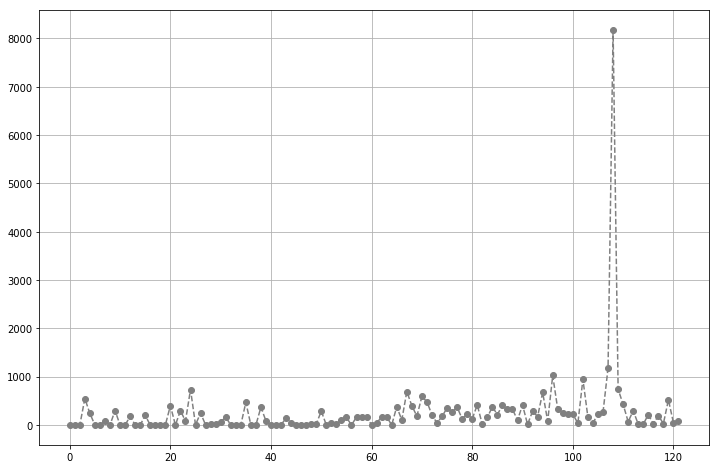

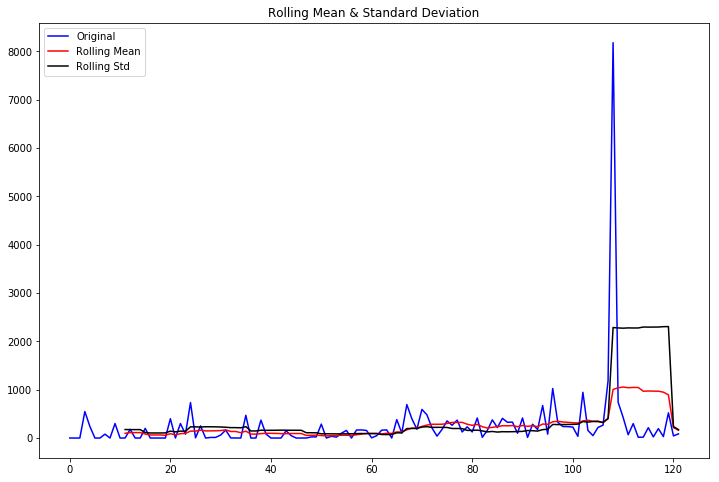

Results of Dickey-Fuller Test:
Test Statistic                -9.152353e+00
p-value                        2.665477e-15
#Lags Used                     0.000000e+00
Number of Observations Used    1.210000e+02
Critical Value (1%)           -3.485585e+00
Critical Value (5%)           -2.885739e+00
Critical Value (10%)          -2.579676e+00
dtype: float64
######################


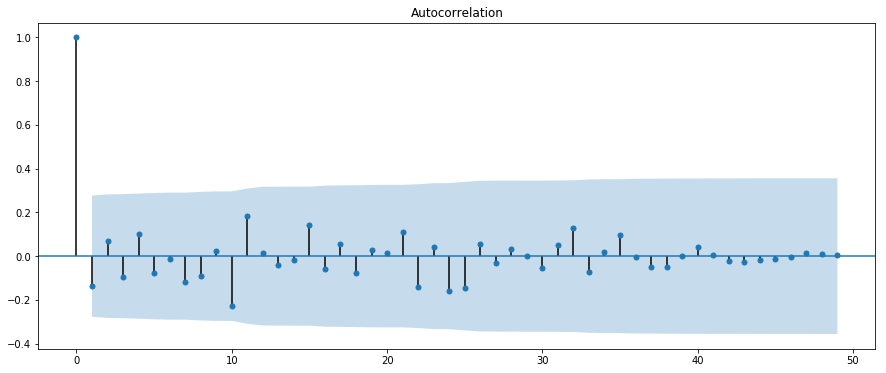

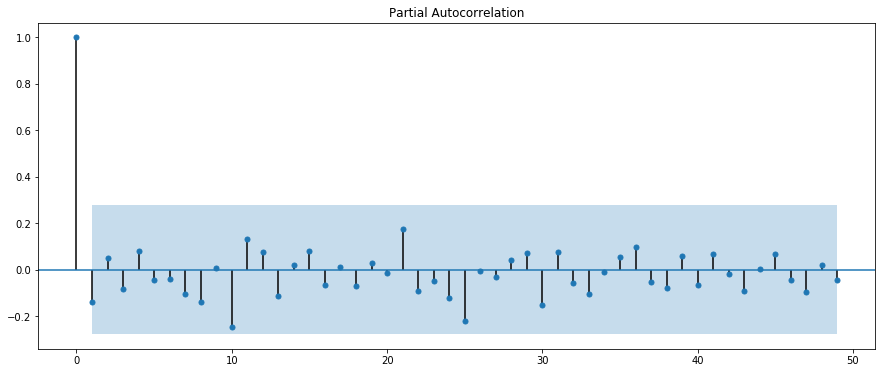

In [97]:
basic(tra)

######################
result of white noice testing (p-value should be small, otherwise: No information in this dataset)
stat                  | p-value
[24.62937733] |
[6.94843572e-07] |
######################


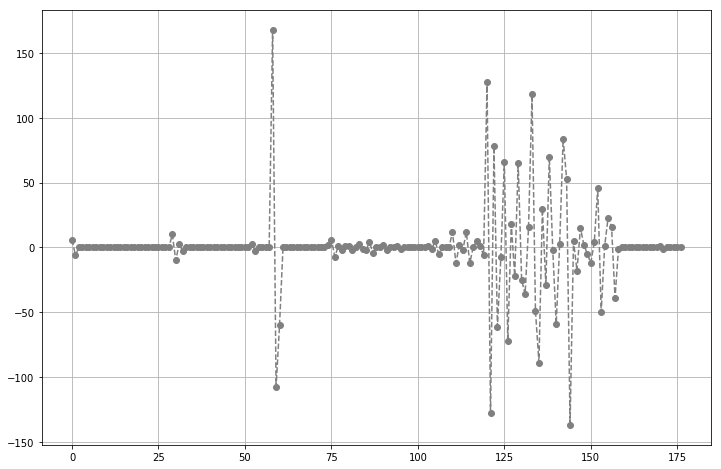

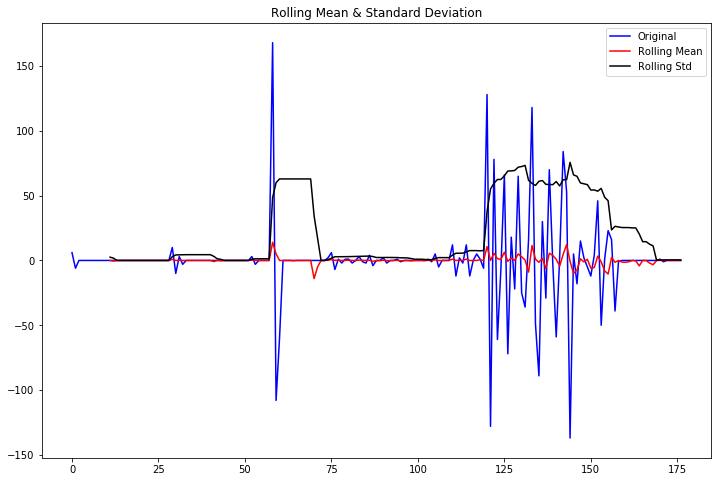

Results of Dickey-Fuller Test:
Test Statistic                -8.820634e+00
p-value                        1.881523e-14
#Lags Used                     7.000000e+00
Number of Observations Used    1.690000e+02
Critical Value (1%)           -3.469648e+00
Critical Value (5%)           -2.878799e+00
Critical Value (10%)          -2.575971e+00
dtype: float64
######################


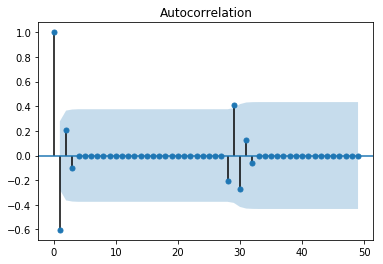

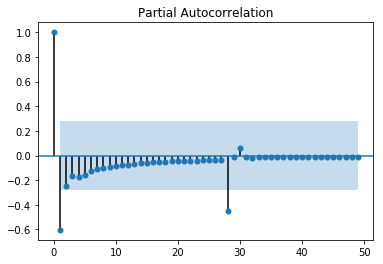

In [56]:
basic(tra.diff(1)[1:])

In [102]:
arima(10,[0,1,2], tra,tes)

        Param         mse          AIC          BIC
69  (7, 2, 0)  104.983464  1997.149681  2022.237106
76  (8, 2, 0)  107.079005  1994.453103  2022.328020
        Param         mse          AIC          BIC
20  (1, 1, 1)  590.522556  1952.750788  1963.933950
12  (0, 1, 2)  592.286212  1952.812340  1963.995502
        Param         mse          AIC          BIC
11  (0, 1, 1)  595.079325  1953.163163  1961.550535
20  (1, 1, 1)  590.522556  1952.750788  1963.933950
        Param         mse          AIC          BIC
11  (0, 1, 1)  595.079325  1953.163163  1961.550535
20  (1, 1, 1)  590.522556  1952.750788  1963.933950


QQ plot of residuals (should be like a straight line)
######################
result of residual's white noice testing (should be very large)
stat                  | p-value
[0.14882543] |
[0.69966035] |
######################
######################
mean squared error:  107.07900504115119
######################
Date
2017-06-05/2017-06-11    -123.318627
2017-06-12/2017-06-18    -511.521353
2017-06-19/2017-06-25       9.050173
2017-06-26/2017-07-02       2.639708
2017-07-03/2017-07-09    -356.991664
2017-07-10/2017-07-16      49.667079
2017-07-17/2017-07-23      67.289284
2017-07-24/2017-07-30     -47.365683
2017-07-31/2017-08-06    -118.000742
2017-08-07/2017-08-13     -38.146867
2017-08-14/2017-08-20     -26.884519
2017-08-21/2017-08-27      38.415691
2017-08-28/2017-09-03      58.784727
2017-09-04/2017-09-10     -16.418381
2017-09-11/2017-09-17    -140.042779
2017-09-18/2017-09-24     -62.928068
2017-09-25/2017-10-01      48.033621
2017-10-02/2017-10-08   -2802.803638
2017-10-09/2017-1

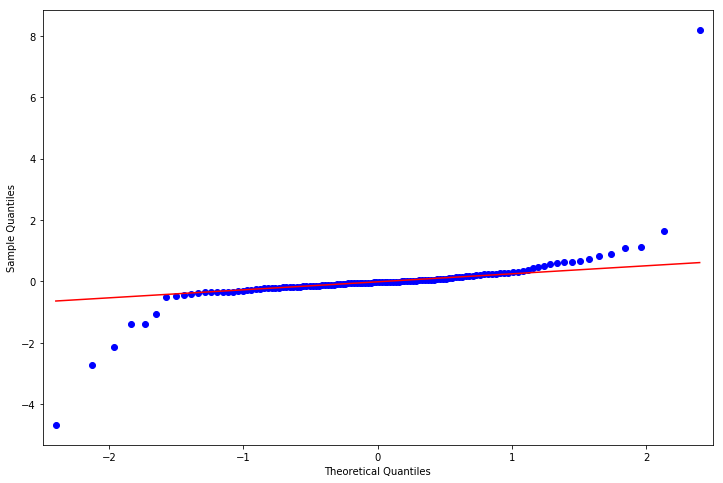

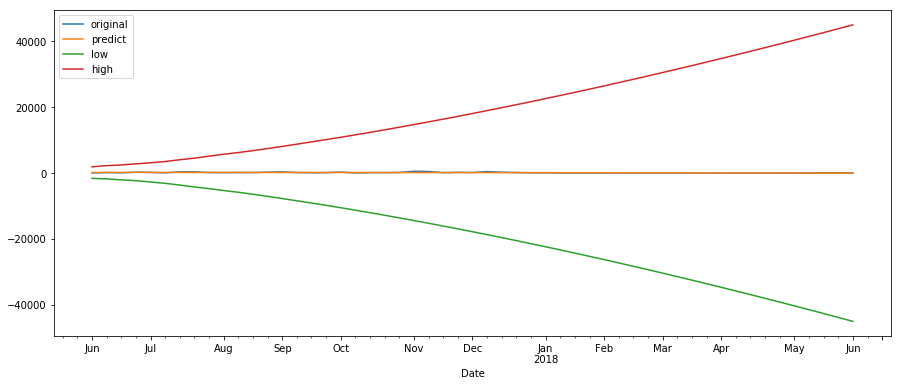

In [105]:
ARIMA_modeling(tra,(8, 2, 0),tes)

In [103]:
sarima(3, [0,1,2], range(0,13),tra,tes)

          Param Seasonal_param         mse          AIC          BIC
3806  (2, 2, 1)   (2, 0, 2, 5)  115.375243  1797.163170  1819.595338
1160  (0, 2, 1)   (2, 0, 2, 2)  117.136040  1915.051495  1931.875621
          Param Seasonal_param          mse          AIC          BIC
8315  (0, 1, 2)  (2, 2, 2, 12)  4275.457317  1178.980700  1198.608848
8306  (0, 1, 2)  (1, 2, 2, 12)  3524.951611  1180.663461  1197.487587
          Param Seasonal_param          mse          AIC          BIC
8306  (0, 1, 2)  (1, 2, 2, 12)  3524.951611  1180.663461  1197.487587
8315  (0, 1, 2)  (2, 2, 2, 12)  4275.457317  1178.980700  1198.608848


                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                  122
Model:             SARIMAX(2, 2, 1)x(2, 0, 2, 5)   Log Likelihood                -890.582
Date:                           Fri, 13 Jul 2018   AIC                           1797.163
Time:                                   14:00:25   BIC                           1819.595
Sample:                                        0   HQIC                          1806.274
                                           - 122                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5410      0.041    -13.329      0.000      -0.621      -0.461
ar.L2         -0.2303      0.051     -4.471

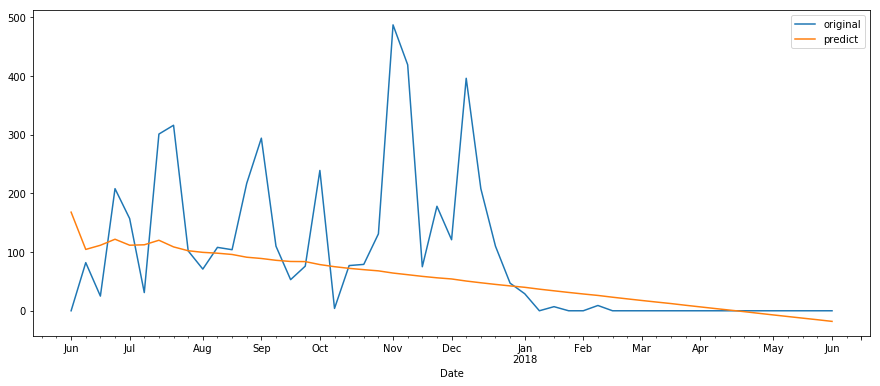

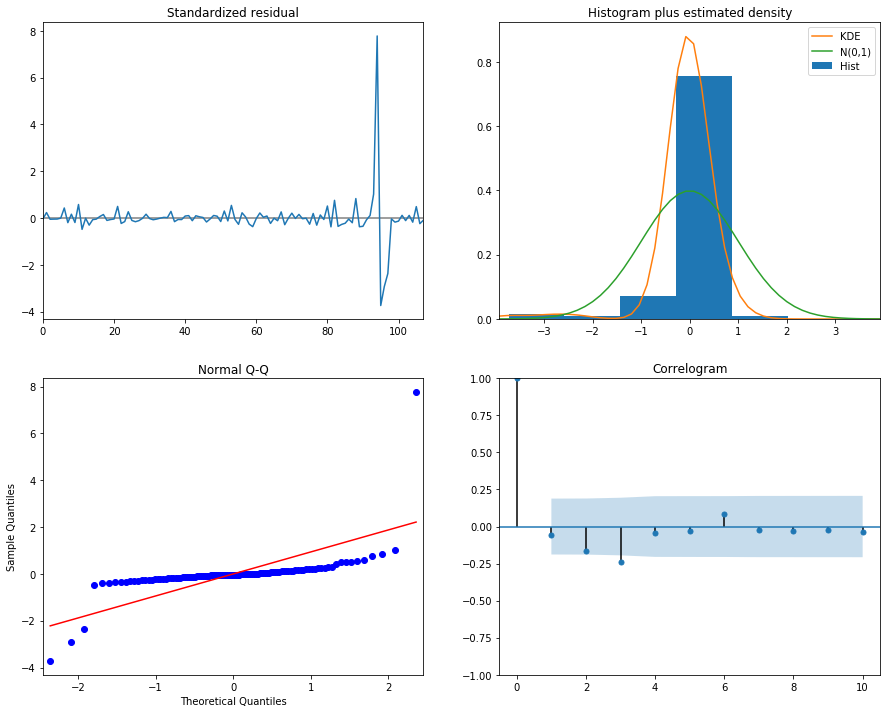

######################
Date
2017-06-05/2017-06-11     -27.435229
2017-06-12/2017-06-18    -346.293219
2017-06-19/2017-06-25      41.418628
2017-06-26/2017-07-02      28.869954
2017-07-03/2017-07-09    -262.560856
2017-07-10/2017-07-16      60.091788
2017-07-17/2017-07-23      65.567724
2017-07-24/2017-07-30      -0.255296
2017-07-31/2017-08-06     -40.160350
2017-08-07/2017-08-13       9.197327
2017-08-14/2017-08-20       7.789583
2017-08-21/2017-08-27      57.964987
2017-08-28/2017-09-03      69.707960
2017-09-04/2017-09-10      21.841048
2017-09-11/2017-09-17     -58.429670
2017-09-18/2017-09-24     -10.212247
2017-09-25/2017-10-01      67.085282
2017-10-02/2017-10-08   -1777.158547
2017-10-09/2017-10-15       6.154602
2017-10-16/2017-10-22      11.371991
2017-10-23/2017-10-29      48.101628
2017-10-30/2017-11-05      86.809059
2017-11-06/2017-11-12      85.334277
2017-11-13/2017-11-19      21.858434
2017-11-20/2017-11-26      68.451527
2017-11-27/2017-12-03      55.215345
2017-12-04

In [108]:
SARIMA_modeling(tra,(2, 2, 1) ,  (2, 0, 2, 5) ,tes)

In [109]:
def prophet(train,test):
    X = pd.DataFrame(index=range(0,len(train)))
    c=[]
    for item in train.index:
        c.append(str(item).split('/')[0])
    X['ds'] = c
    X['y'] = train.values
    m = Prophet()
    m.fit(X)
    future_data = m.make_future_dataframe(periods=len(test), freq = 'w')
    forecast_data = m.predict(future_data)
    m.plot(forecast_data)
    predict=list(forecast_data['yhat'][-len(test):])
    original=list(test)
    comp = pd.DataFrame()
    comp['original'] = original
    comp['predict'] = predict
    comp.plot()
    comp = comp[comp.original!=0]
    q=((comp['original']-comp['predict'])/comp['original'])*100
    print(q)
    print('average Delta: ',np.mean(abs(q)), '%')

In [110]:
def Naive(train,test):
    data=list(train[-len(test):])
    r=[]
    for i in range(len(data)):
        r.append(np.mean(data[i:]+r))
    original=list(test)
    comp = pd.DataFrame()
    comp['original'] = original
    comp['predict'] = r
    comp.plot()
    comp = comp[comp.original!=0]
    q=((comp['original']-comp['predict'])/comp['original'])*100
    print(q)
    print('average Delta: ',np.mean(abs(q)), '%')

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1      -661.617612
2     -2593.924268
3      -179.533885
4      -215.577655
5     -1707.654589
6      -139.138381
7      -146.595398
8      -538.707388
9      -558.534211
10     -282.309217
11     -383.967059
12     -169.979835
13      -87.273952
14     -326.878263
15     -816.718911
16     -703.690781
17     -194.534612
18   -16383.472201
19     -606.844168
20     -537.547803
21     -330.607600
22      -25.005274
23      -33.385007
24     -571.711454
25     -226.189854
26     -522.387174
27     -104.205046
28     -199.919303
29     -234.371288
30     -628.483697
31    -1997.153725
33   -11040.581750
36    -7711.979511
dtype: float64
average Delta:  1541.226693036662 %


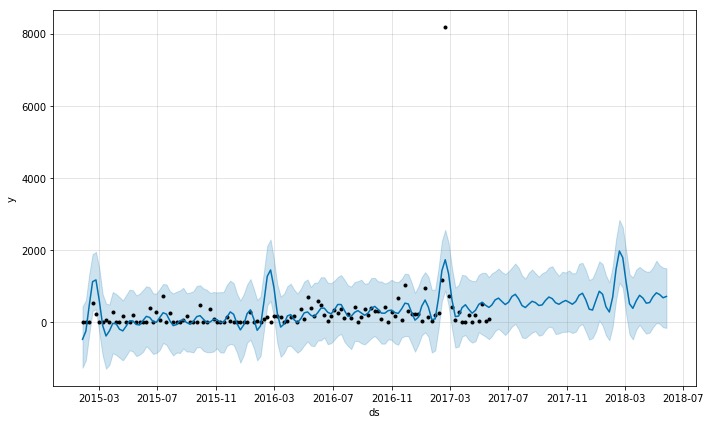

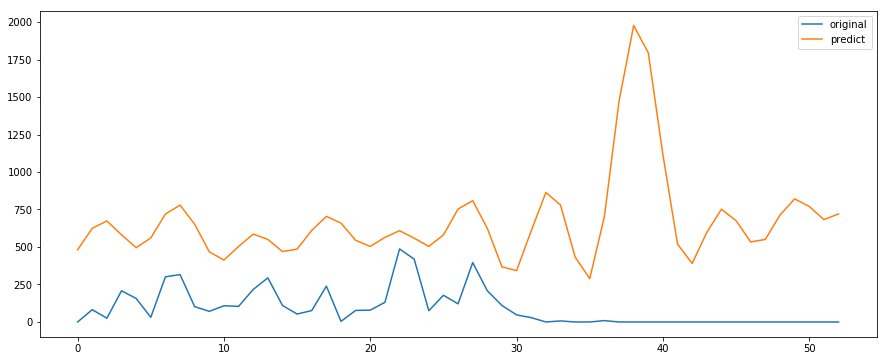

In [111]:
prophet(tra,tes)

1      -432.886888
2     -1636.168407
3      -108.257198
4      -178.601712
5     -1335.231477
6       -49.487713
7       -42.964730
8      -346.365177
9      -543.497049
10     -328.820351
11     -349.506583
12     -118.400919
13      -61.578871
14     -339.747197
15     -824.278515
16     -547.389551
17     -108.035582
18   -12372.675564
19     -552.168077
20     -539.793376
21     -291.669097
22       -5.736593
23      -25.156974
24     -605.233128
25     -200.889778
26     -340.472875
27      -36.747178
28     -155.959874
29     -387.519949
30    -1052.937976
31    -1788.455812
33    -7950.118359
36    -6272.445308
dtype: float64
average Delta:  1209.9756920504346 %


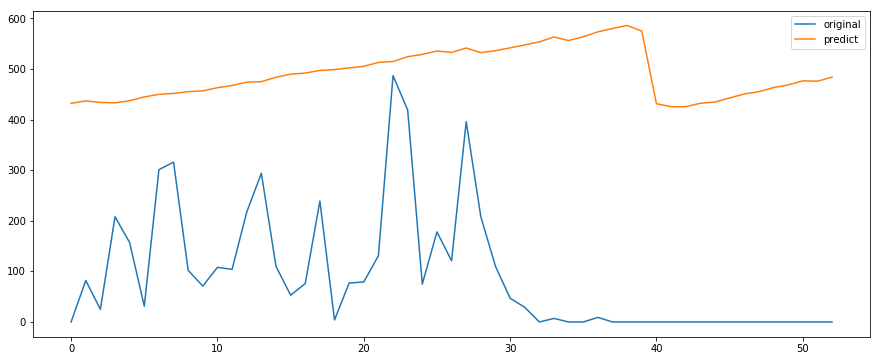

In [112]:
Naive(tra,tes)